<a href="https://colab.research.google.com/github/eshansurendra/AerialSeg-U-Net/blob/main/notebook/Semantic_segmentation_of_aerial_(satellite)_imagery_using_U_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries in Colab
!pip install opencv-python-headless  # Sometimes, the headless version is preferable in Colab to avoid GUI issues

In [ ]:
# Uninstall the current versions first if there are conflicts
!pip uninstall tensorflow keras -y

# Reinstall specific compatible versions
!pip install tensorflow==2.9.1
!pip install keras==2.9.0

# Install segmentation-models
!pip install -U segmentation-models

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
Found existing installation: keras 2.15.0
Uninstalling keras-2.15.0:
  Successfully uninstalled keras-2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 41.5 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 24.3.25
    Uninstalling flatbuffers-24.3.

In [ ]:
!pip install -U segmentation-models

In [ ]:
!pip install matplotlib
!pip install scikit-learn

In [ ]:
!pip install patchify

In [ ]:
!pip install Pillow

In [ ]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler

Segmentation Models: using `keras` framework.


In [ ]:
scaler = MinMaxScaler()

In [ ]:
#Unzip the file
import zipfile
import os

# Specify the file name
zip_file_name = "/content/Semantic segmentation dataset.zip"

# Specify the target folder where you want to unzip
target_folder = "/content/Semantic segmentation dataset"

# Create the target folder if it doesn't exist
if not os.path.exists(target_folder):
    os.makedirs(target_folder)

# Unzip the file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(target_folder)

# Check if extraction was successful
if len(os.listdir(target_folder)) > 0:
    print("Extraction completed successfully.")
else:
    print("Extraction failed.")

Extraction completed successfully.


In [ ]:
root_directory = '/content/Semantic segmentation dataset/Semantic segmentation dataset'
patch_size = 256

In [ ]:
#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then
#divide all images into patches of 256x256x3.
image_dataset = []
for path, subdirs, files in os.walk(root_directory):
    #print(path)
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):
            if image_name.endswith(".jpg"):   #Only read jpg images...

                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)

                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):

                        single_patch_img = patches_img[i,j,:,:]

                        #Use minmaxscaler instead of just dividing by 255.
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)

                        #single_patch_img = (single_patch_img.astype('float32')) / 255.
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.
                        image_dataset.append(single_patch_img)

Now patchifying image: /content/Semantic segmentation dataset/Semantic segmentation dataset/Tile 8/images/image_part_005.jpg
Now patchifying image: /content/Semantic segmentation dataset/Semantic segmentation dataset/Tile 8/images/image_part_006.jpg
Now patchifying image: /content/Semantic segmentation dataset/Semantic segmentation dataset/Tile 8/images/image_part_007.jpg
Now patchifying image: /content/Semantic segmentation dataset/Semantic segmentation dataset/Tile 8/images/image_part_004.jpg
Now patchifying image: /content/Semantic segmentation dataset/Semantic segmentation dataset/Tile 8/images/image_part_001.jpg
Now patchifying image: /content/Semantic segmentation dataset/Semantic segmentation dataset/Tile 8/images/image_part_008.jpg
Now patchifying image: /content/Semantic segmentation dataset/Semantic segmentation dataset/Tile 8/images/image_part_003.jpg
Now patchifying image: /content/Semantic segmentation dataset/Semantic segmentation dataset/Tile 8/images/image_part_002.jpg


In [ ]:
 #Now do the same as above for masks
 #For this specific dataset we could have added masks to the above code as masks have extension png
mask_dataset = []
for path, subdirs, files in os.walk(root_directory):
    #print(path)
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)

                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)

                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):

                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.
                        mask_dataset.append(single_patch_mask)


Now patchifying mask: /content/Semantic segmentation dataset/Semantic segmentation dataset/Tile 8/masks/image_part_002.png
Now patchifying mask: /content/Semantic segmentation dataset/Semantic segmentation dataset/Tile 8/masks/image_part_008.png
Now patchifying mask: /content/Semantic segmentation dataset/Semantic segmentation dataset/Tile 8/masks/image_part_009.png
Now patchifying mask: /content/Semantic segmentation dataset/Semantic segmentation dataset/Tile 8/masks/image_part_006.png
Now patchifying mask: /content/Semantic segmentation dataset/Semantic segmentation dataset/Tile 8/masks/image_part_001.png
Now patchifying mask: /content/Semantic segmentation dataset/Semantic segmentation dataset/Tile 8/masks/image_part_004.png
Now patchifying mask: /content/Semantic segmentation dataset/Semantic segmentation dataset/Tile 8/masks/image_part_003.png
Now patchifying mask: /content/Semantic segmentation dataset/Semantic segmentation dataset/Tile 8/masks/image_part_007.png
Now patchifying 

In [ ]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

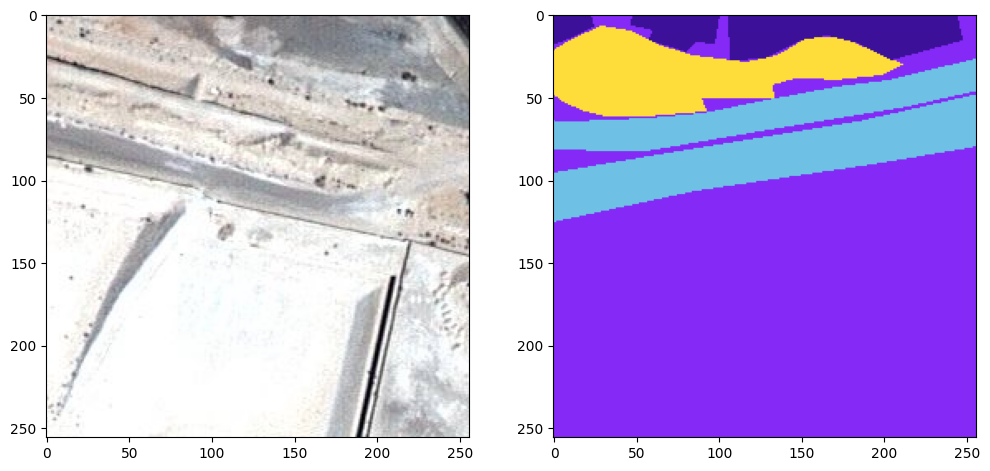

In [ ]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()